In [2]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, datasets, callbacks

### Data Prepration

In [3]:
(x_train,y_train),(x_test,y_test)=datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [4]:
def preproces(images):
  images=images.astype("float32")/255.0
  images=np.pad(images,((0,0),(2,2),(2,2)),"constant",constant_values=0.0)
  images=np.expand_dims(images,axis=-1)
  return images



In [5]:
x_train=preproces(x_train)
x_test=preproces(x_test)

In [6]:
### Helper Functions to Display Images

In [7]:
def sample_batch(dataset):
  batch= dataset.take(1).get_single_element()
  if isinstance(batch, tuple):
    batch = batch[0]
  return batch.numpy()

def display_images(images, number_images_to_display=10, size=(20,3), cmap="gray_r", as_type="float32"):
  if images.max()>1.0:
    images=images/255.0
  elif images.min() <0.0:
    images = (images+1.0)/2.0

  plt.figure(figsize=size)

  for i in range(number_images_to_display):
    x1 = plt.subplot(1, number_images_to_display, i+1)
    plt.imshow(images[i].astype(as_type), cmap=cmap)
    plt.axis("off")

  plt.show()

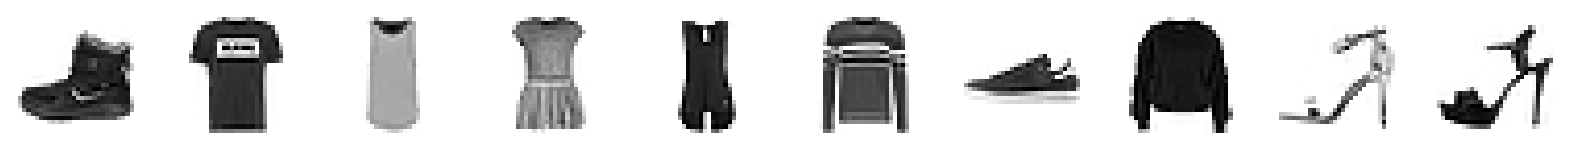

In [8]:
display_images(x_train)

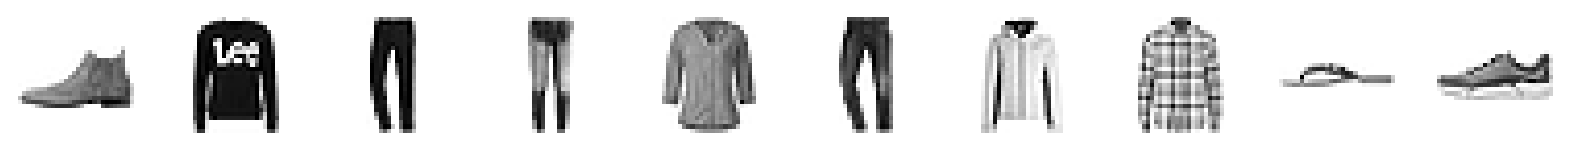

In [9]:
display_images(x_test)

### Design AutoEncoder

In [10]:
IMAGE_SIZE=32
CHANNELS=1
EPOCHS=5
EMBEDDING_DIM=2
BATCH_SIZE=100
BUFFER_SIZE=1000
VALIDATION_SPLIT=0.2


In [11]:
# Encoder
# input encoder

encoder_input=layers.Input(
    shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),
    name="encoder_input"

)
#stack of convo2D layers
x=layers.Conv2D(32,(3,3),strides=2,activation="relu",padding="same")(encoder_input)
x=layers.Conv2D(64,(3,3),strides=2,activation="relu",padding="same")(x)
x=layers.Conv2D(128,(3,3),strides=2,activation="relu",padding="same")(x)


# flatten the output from last convolution layer to a vector
shape_before_flatten=K.int_shape(x)[1:] # Required in future by decoder
x=layers.Flatten()(x)

# Dense layer which will connect this flatten vector to 2D embeddings/context vector
encoder_output=layers.Dense(EMBEDDING_DIM,name="encoder_output")(x)
encoder=models.Model(encoder_input,encoder_output)

# Print Model's summary

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [12]:
#DECODER

#Input layer
decoder_input = layers.Input(shape=(2,), name="decoder_input_layer")

#connect input to Dense Layer
x = layers.Dense(np.prod(shape_before_flatten))(decoder_input)

#reshaping to feed as input to first Conv2DTranspose layer
x = layers.Reshape(shape_before_flatten)(x)

#stack of conv2DTranspose layers
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)

decoder_output = layers.Conv2D(1, (3,3), strides=1, activation="sigmoid", padding="same", name="decoder_output_layer")(x)

decoder = models.Model(decoder_input, decoder_output)

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input_layer (Input  [(None, 2)]               0         
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                           

## Join Encoder to Decoder

In [13]:
autoencoder=models.Model(
    encoder_input,decoder(encoder_output)
  )
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

## Training our Autoencoder


In [14]:
autoencoder.compile(
    optimizer="adam",
    loss="binary_crossentropy"
)

In [15]:
model_checkpoint = callbacks.ModelCheckpoint(
    filepath = "./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor="loss",
    mode="min",
    save_best_only = True,
    verbose=0
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./tensorboard_logs")

In [16]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data = (x_test, x_test),
    callbacks = [model_checkpoint, tensorboard_callback]
)

Epoch 1/5
600/600 [==============================] - 15s 13ms/step - loss: 0.2947 - val_loss: 0.2646
Epoch 2/5
600/600 [==============================] - 8s 13ms/step - loss: 0.2594 - val_loss: 0.2584
Epoch 3/5
600/600 [==============================] - 7s 12ms/step - loss: 0.2552 - val_loss: 0.2555
Epoch 4/5
600/600 [==============================] - 8s 13ms/step - loss: 0.2531 - val_loss: 0.2542
Epoch 5/5
600/600 [==============================] - 8s 13ms/step - loss: 0.2515 - val_loss: 0.2527


In [17]:
#save the checkpoints / trained model

autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## Reconstruct Images using our trained Autoencoder

In [18]:
number_images = 5000
example_images = x_test[:number_images]
example_labels = y_test[:number_images]


In [19]:

predicted_images = autoencoder.predict(example_images)

157/157 [==============================] - 1s 3ms/step


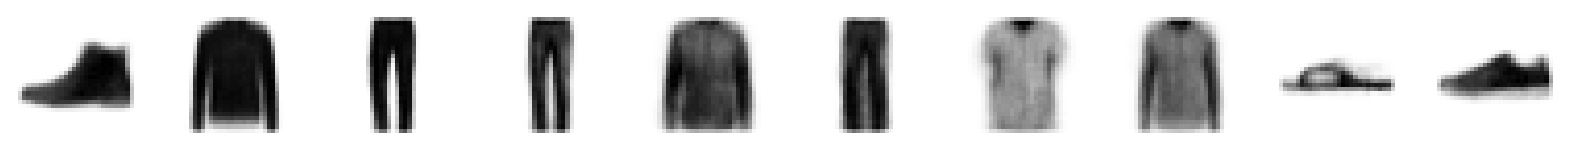

In [21]:
display_images(predicted_images, number_images_to_display=10)


In [22]:
 #visualize embeddings /Latent Space

embeddings = encoder.predict(example_images)

157/157 [==============================] - 1s 3ms/step


In [23]:
print(embeddings[:10])

[[ 2.2828658   2.6690955 ]
 [-1.4505296  -2.51969   ]
 [-9.546848    4.9662533 ]
 [-5.964438    3.93981   ]
 [-0.7299679  -0.8011413 ]
 [-5.968204    2.4415421 ]
 [-1.8038073   0.47715658]
 [-1.2207818  -0.5151233 ]
 [-1.0108602   5.444196  ]
 [ 0.72111475  4.8985534 ]]


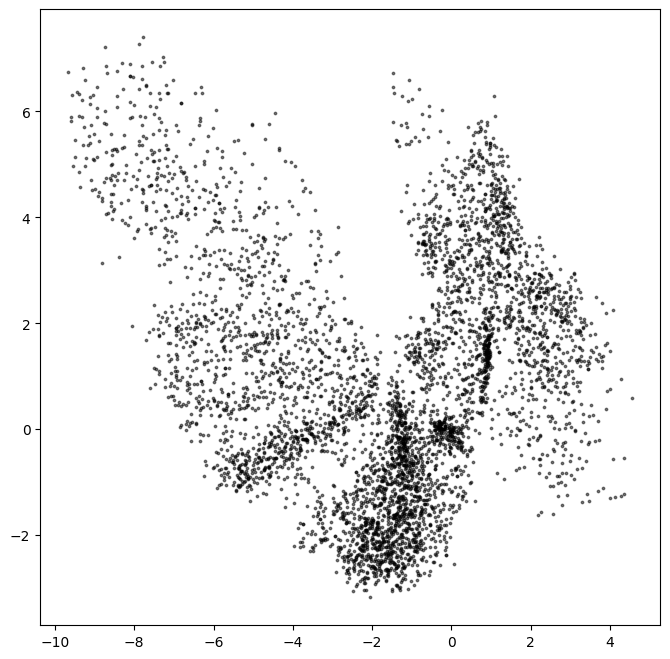

In [28]:
fig_size = 8

plt.figure(figsize=(fig_size,fig_size))
plt.scatter(embeddings[:,0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

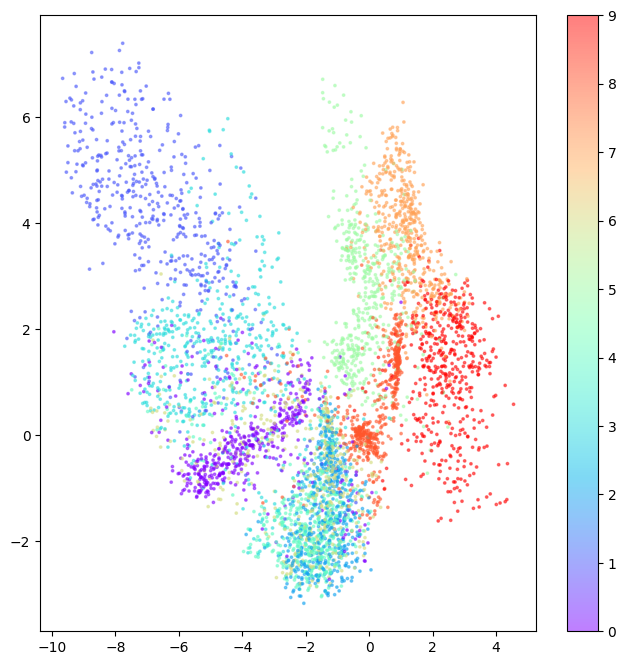

In [26]:
#color the embeddings as per label ids

example_labels = y_test[:number_images]

plt.figure(figsize=(fig_size,fig_size))
plt.scatter(
    embeddings[:,0], embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.5,
    s=3
)
plt.colorbar()
plt.show()

## Lets try to generate NEW IMAGES

In [32]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

grid_width, grid_height = (6,3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width*grid_height, EMBEDDING_DIM)
)

In [33]:
#Decode the sample points
sample

array([[-5.57687331,  0.47541108],
       [ 1.33957845,  3.16690767],
       [ 2.89731145, -2.56825838],
       [-2.70889232,  3.16656821],
       [-2.84491243,  3.09856761],
       [-9.12208652,  4.02823989],
       [-7.88430154,  1.18200267],
       [-6.89667905, -2.75130991],
       [ 4.43661527, -0.41486695],
       [-9.35784416, -2.76457221],
       [ 2.03648746,  0.15575567],
       [ 1.12337285, -2.42806093],
       [-5.03724096,  5.94002581],
       [-0.35576187,  1.36228533],
       [-7.30845351,  6.71917473],
       [ 2.54378009,  0.03921003],
       [-1.66254719,  6.34529031],
       [-2.40697135,  6.01806682]])

In [34]:

reconstrcted_images = decoder.predict(sample)

1/1 [==============================] - 0s 285ms/step


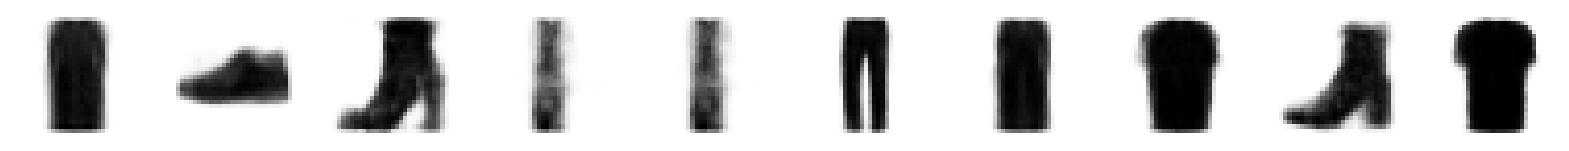

In [35]:
display_images(reconstrcted_images)

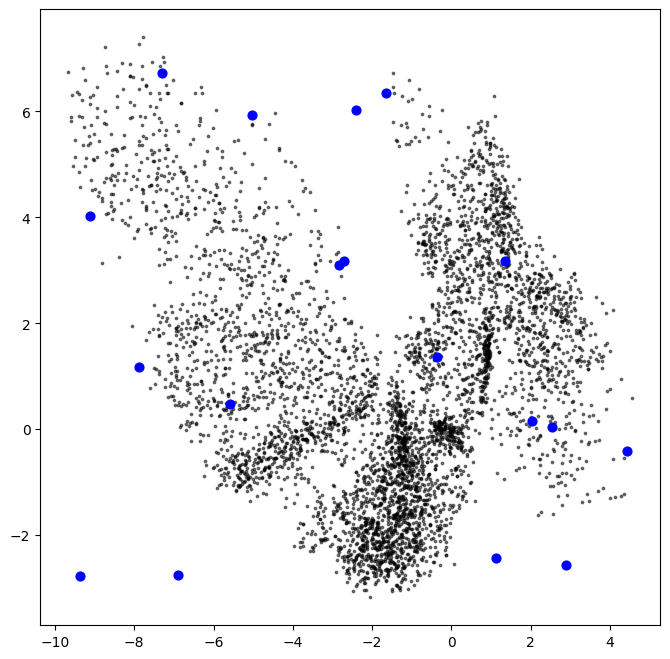

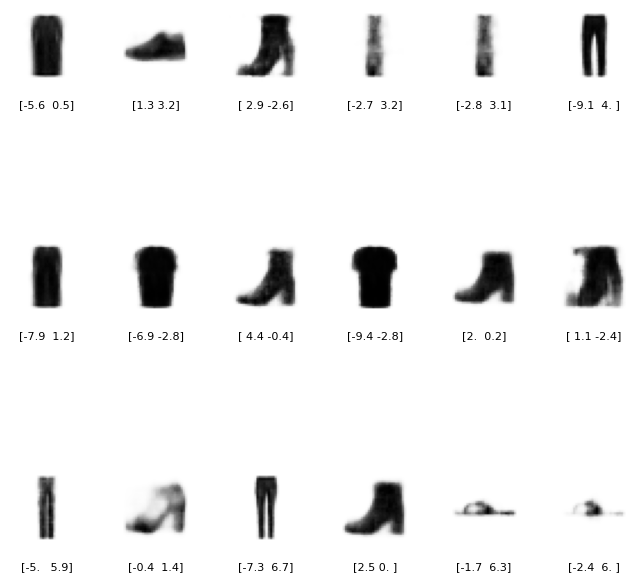

In [36]:
# reason why we are getting few blured images
plt.figure(figsize=(fig_size, fig_size))
plt.scatter(embeddings[:,0], embeddings[:, 1], c="black", alpha=0.5, s=3)

#newly generated points plotting
plt.scatter(sample[:,0], sample[:,1], c="#0000FF", alpha=1, s=40)
plt.show()

fig = plt.figure(figsize=(fig_size, fig_size))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(grid_width*grid_height):
  ax = fig.add_subplot(grid_height, grid_width, i+1)
  ax.axis("off")
  ax.text(
      0.5,
      -0.35,
      str(np.round(sample[i,:], 1)),
      fontsize=8,
      ha="center",
      transform=ax.transAxes
  )
  ax.imshow(reconstrcted_images[i, :, :], cmap="Greys")